In [1]:
import csv
import os
import random
import sys


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  pwlf
from scipy import linalg
DATA_SIZE = 10000
BLOCK_SIZE = 10
FACTOR=10


In [2]:
from scipy.optimize import nnls 
from scipy.optimize import lsq_linear

In [41]:
import  pwlf

In [3]:
filename = os.path.join("data//2d_lognormal_1000000.csv")
in_data = pd.read_csv(filename)
# For functionality testing we want to work with smaller dataset
in_data.drop(in_data.tail(990000).index,inplace=True) # drop last n rows

In [4]:
#in_data['y'] = 1395-in_data['y']
in_data.dropna(how='all',inplace=True)

In [5]:
in_data.shape

(10000, 3)

In [6]:
#Initialize Hyperparmeters
# Some of these hyperparameters have been choosen to move faster in the implementation
# they will be revisited once end to end functionality is up. 
np.set_printoptions(threshold=np.inf)
CellSize = 10
x_range = max(in_data.x)
y_range = max(in_data.y)
NuOfKeys = in_data.shape[0]
KeysPerCell =  NuOfKeys // (CellSize*CellSize)
print(x_range)
print(y_range)
print(NuOfKeys)
print(KeysPerCell)

6843539
6843539
10000
100


In [10]:
in_data_arr = in_data.to_numpy()
in_data_arr = in_data_arr.astype('float64') 

in_data_arr = in_data_arr[in_data_arr[:,0].argsort()]
# Initialize Cell Matrix, Each element of cell matrix has [(l0, u0 ), (l1, u1), Cell Id, CellId*KeysPerCell]
# We  keep cell id and CellId*KeysPerCell in 2 mappings,position 5, 6, is mapping value increasing in x direction
# position 7 8 is , mapping value increasing in y direction. 
cellMatrix = np.zeros((CellSize*CellSize, 9))
# Divie X axis into equal no of keys, and fill x values for the cell
for i in range(CellSize):
    for j in range(CellSize):
        cellMatrix[i*CellSize+j][0] =  in_data_arr[(KeysPerCell*CellSize*(j))-(not(not(j%CellSize))) ,0]
        cellMatrix[i*CellSize+j][2] =  in_data_arr[(KeysPerCell*CellSize*(j+1)) -1 ,0]
        cellMatrix[i*CellSize+j][4] =  i*CellSize+j
        cellMatrix[i*CellSize+j][5] =  (KeysPerCell*CellSize*i)+j*KeysPerCell
        cellMatrix[i*CellSize+j][6] =  i + CellSize*j
        cellMatrix[i*CellSize+j][7] =  (i*KeysPerCell)+(KeysPerCell*CellSize*j)
        

# Sort Keys along y direction
for i in range(CellSize):
    in_data_arr[KeysPerCell*CellSize*i:KeysPerCell*CellSize*(i+1)] = in_data_arr[(in_data_arr[KeysPerCell*CellSize*i:KeysPerCell*CellSize*(i+1),1].argsort())++KeysPerCell*CellSize*i]
# Divide the keys along y Axis
for i in range(CellSize):
    for j in range(CellSize):
        cellMatrix[i*CellSize+j][1] =  in_data_arr[((KeysPerCell*(i-1)) + (KeysPerCell*CellSize*j) +(KeysPerCell-1)) ,1]
        cellMatrix[i*CellSize+j][3] =  in_data_arr[((KeysPerCell*i) + (KeysPerCell*CellSize*j) +(KeysPerCell-1)) ,1]
        #print(((KeysPerCell*(i-1)) + (KeysPerCell*CellSize*(j)) +(KeysPerCell-1)))
        #print( ((KeysPerCell*(i)) + (KeysPerCell*CellSize*(j)) +(KeysPerCell-1)))
        cellMatrix[i*CellSize+j][8] =  ((cellMatrix[i*CellSize+j][3] - cellMatrix[i*CellSize+j][1])*
                                        (cellMatrix[i*CellSize+j][2] - cellMatrix[i*CellSize+j][0]))

# Bookkeeping code        
for i in range(CellSize):
    cellMatrix[i][1] =  0
    cellMatrix[i][8] =  np.abs((cellMatrix[i][3] - cellMatrix[i][1])*
                     (cellMatrix[i][2] - cellMatrix[i][0]))
# Add 1 more column in input data array to hold mapped value. 
in_data_arr =np.hstack((in_data_arr, np.zeros((in_data_arr.shape[0], 1), dtype=in_data_arr.dtype)))

In [11]:
'''
Calculate Mapping Value using Lebesgue Measurement
Following step are followed
a) For each key value pair in input np array
    Find the corresponding cell
    Mapped Value = i+area(ui)/area(ci)
    Store the mapped value in data array
'''
j = 0
k = 0
l = 0
for i in range(0,in_data_arr.shape[0]):
    Idx = (((i% KeysPerCell)))
    CellIdx = j*CellSize +k
    #print(' i = %d idx = %d, cellIdx = %d'%(i, Idx, CellIdx))
    KeyArea = ((in_data_arr[i][1] - cellMatrix[CellIdx][1])*
               (in_data_arr[i][0] - cellMatrix[CellIdx][0]))
     
    in_data_arr[i, 3] =   cellMatrix[CellIdx][7] + ((KeyArea/cellMatrix[CellIdx][8])*KeysPerCell)
    #print('KeyArea = %d , m_v = %f' %(KeyArea, in_data_arr[i][3]))
    #print('x1 = %d y1 = %d x0 = %d y0 = %d ' %(in_data_arr[i][0], in_data_arr[i][1], cellMatrix[CellIdx][0], cellMatrix[CellIdx][1]))
    if(Idx ==(KeysPerCell -1) ):
        #print('\n\n')
        j  = j+1
        if(j == CellSize):
            k = k+1
            j = 0
# Sort the input data array with mapped values
in_data_arr = in_data_arr[in_data_arr[:,3].argsort()]        

In [12]:
# Choose a small range of mapped values for shard training functionality testing
x= in_data_arr[0:100,3]
y= np.arange(100)

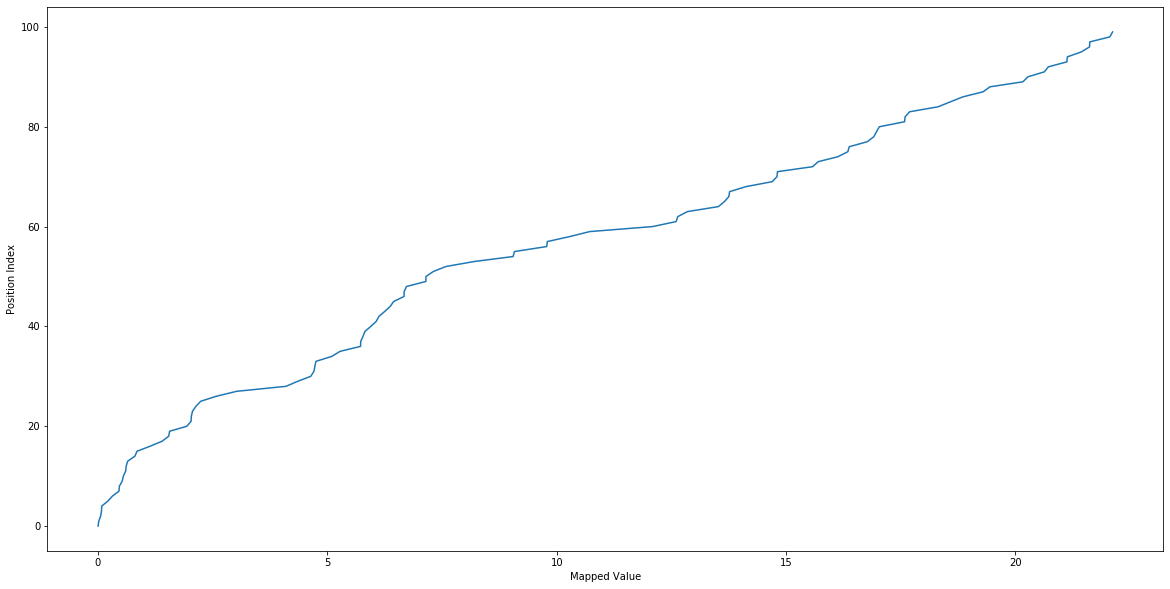

In [14]:
# Plot relationship between mapped values(x) and location of the key in the partition
plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel('Mapped Value')
plt.ylabel('Position Index')
plt.show()

In [ ]:
#Shard Training Code Implementation

In [26]:
'''
Convert input data to np array
'''
def convert_to_np_array(input_):
        if isinstance(input_, np.ndarray) is False:
            input_ = np.array(input_)
        return input_


In [27]:
'''
    Get Initial set of betas, referred to by breaks
    Parameters
    ----------
    input_ : array_like
        The object containing mapped values for the interval.
    V : Integer
        Repersents the nu of keys in the interval
    D : Integer
        Nu of shards(line segments/slopes-intercepts values) needs to be learned from training data

    Returns
    -------
    b_ : numpy array
        The x(mapped value) locations where each line segment terminates. Referred to 
        as breakpoints for each line segment and should be structured as a 1-D numpy array.
'''
def get_breaks(input_, V= 16, D = 4):
        b_ = np.zeros( D +1)
        b_[0], b_[-1] = np.min(input_), np.max(input_)
        i = 1
        while(i<(D)):
            b_[i] = input_[i*(V//D)]
            print(i*(V//D))
            i = i+1            
        return b_


In [28]:
'''
    Assemble the matrix A
    Parameters
    ----------
    breaks : np array
        The x(mapped value) locations where each line segment terminates. Referred to 
        as breakpoints for each line segment and should be structured as a 1-D numpy array.
    x : np array
        The x locations which the linear regression matrix is assembled on.
        This must be a numpy array!
    Returns
    -------
    A : ndarray (2-D)
        The assembled linear regression matrix.
 
 '''
def assemble_regression_matrix(breaks, x):
        breaks = convert_to_np_array(breaks)
        # Sort the breaks
        breaks_order = np.argsort(breaks)
        fit_breaks = breaks[breaks_order]
        # Fetch number of parameters and line segments
        n_segments = len(breaks) - 1

        # Assemble the regression matrix
        A_list = [np.ones_like(x)]
        A_list.append(x - fit_breaks[0])
        for i in range(n_segments - 1):
            A_list.append(np.where(x >= fit_breaks[i+1],
                                       x - fit_breaks[i+1],
                                       0.0))
        A = np.vstack(A_list).T
        return A, fit_breaks,n_segments

In [29]:
'''
    Compute line segments slope after a piecewise linear
    function has been fitted.
    This will also calculate the y-intercept from each line in the form
    y = mx + b. 
    Parameters
    ----------
    y_hat : np array
        Predicted value of the Sharding Function
    fit_breaks : np array
        The x locations which the linear regression matrix is assembled on.
        This must be a numpy array!
    n_segments
        Number of line segments to learn
        
    Returns
    -------
    slopes : ndarray(1-D)
        The slope of each ling segment as a 1-D numpy array.Slopes[0] is the slope
        of the first line segment.
    Intercepts : ndarray(1-D)
        The intercept of each ling segment as a 1-D numpy array.Intercept[0] is the slope
        of the first line segment.
'''
def compute_slopes(y_hat,fit_breaks,n_segments):
    slopes = np.divide(
                    (y_hat[1:n_segments + 1] -
                     y_hat[:n_segments]),
                    (fit_breaks[1:n_segments + 1] -
                     fit_breaks[:n_segments]))
    intercepts = y_hat[0:-1] - slopes * fit_breaks[0:-1]
    return slopes, intercepts

In [30]:
'''
    Compute least square fit(alphas) for the A matrix
    This will also calculate the y-intercept from each line in the form
    y = mx + b. 
    Parameters
    ----------
    A : np array(2-D)
        Assembled Linear Regression Matrix
    y_data : np array 
        Array conatinaing the label values
       
        
    Returns
    -------
    alpha : ndarray(1-D)
       Cofficients of Least square solution
    SSR : Float
        Cost value at the Least square solution
    r:  ndarray(1-D)
        Residual Error
'''
def lstsq(A, y_data):
    
    #alpha, ssr, _, _ = linalg.lstsq(A, y_data)
    alpha, ssr = nnls(A,y_data)
  
    #res= lsq_linear(A, y_data, bounds=(0,   22.11773239), lsmr_tol='auto', verbose=1)
    # ssr is only calculated if self.n_data > self.n_parameters
    # in this case I'll need to calculate ssr manually
    # where ssr = sum of square of residuals
    #alpha = res.x
    #ssr = res.cost
    y_hat = np.dot(A, alpha)
    e = y_hat - y_data
    '''
    if n_data <= n_parameters:
        ssr = np.dot(e, e)
    if isinstance(ssr, list):
        ssr = ssr[0]
    elif isinstance(ssr, np.ndarray):
        if ssr.size == 0:
            y_hat = np.dot(A, alpha)
            e = y_hat - y_data
            ssr = np.dot(e, e)
        else:
            ssr = ssr[0]

    '''
    return alpha,ssr, e  

In [31]:
'''
    Predict location of key in the interval. 
    Parameters
    ----------
    x : np array(2-D)
        Mapped Values Array
    alpha : np array 
        Least square solution cofficients
    breaks : np array 
        Array containing termination point for line segments
         
    Returns
    -------
    y_hat : ndarray(1-D)
       Predicted value of Least square solution
'''
def predict(x, alpha=None, breaks=None):
        
        if alpha is not None and breaks is not None:
            alpha = alpha
            # Sort the breaks, then store them
            breaks_order = np.argsort(breaks)
            fit_breaks = breaks[breaks_order]
            n_parameters = len(fit_breaks)
            n_segments = n_parameters - 1

        x = convert_to_np_array(x)

        A,_,_ = assemble_regression_matrix(fit_breaks, x)

        # solve the regression problem
        y_hat = np.dot(A, alpha)
        return y_hat


In [32]:
'''
   Return whether input matrix is Positive deifnite or not. 
'''
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [37]:
'''
    Calculate gradient update for beta(breakpoints)
    Parameters
    ----------
    x : np array(2-D)
        Mapped Values Array
    alpha : np array 
        Least square solution cofficients
    fit_breaks : np array 
        Array containing termination point for line segments
    r_error : np array 
       Error Residual from least square solutiuon
    n_segments : Interger
        Number of line segments(Shard Id) to learn
    Returns
    -------
    s : ndarray(1-D)
       Gradient update for next iteration 
'''
def calc_gradient(x, alpha, fit_breaks,r_error,n_segments):
    K = np.diag(alpha)
    G_list = [np.ones_like(x)]
    G_list.append(x - fit_breaks[0])
    for i in range(n_segments - 1):
        G_list.append(np.where(x >= fit_breaks[i+1],
                               x - fit_breaks[i+1],
                               np.inf))
    G = np.vstack(G_list)
    G= ((G!=np.inf).astype(int)*(-1))
    KG = np.dot(K, G)
    g= 2*(KG.dot(r_error))
    Y = 2*(KG.dot(np.transpose(KG)))
    print('Y is PD %d'%(is_pos_def(Y)))
    try:
        Y_inverse = np.linalg.inv(Y)
        s = -Y_inverse.dot(g)
    except np.linalg.LinAlgError:
        print('Y_inverse not avaliable')
        s = 0
    pass
    
    return s

In [38]:
x, y = convert_to_np_array(x), convert_to_np_array(y)
x_data, y_data = x, y
n_data = x.size
ssr_list= []
bp_list = []
breaks = get_breaks(x_data,n_data)
lr = 0.1

25
50
75


ssr is 45.075101


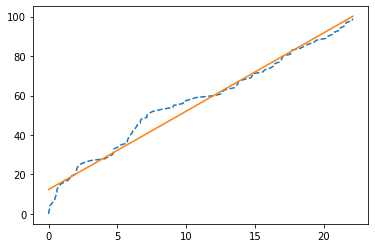

Y is PD 0
Y_inverse not avaliable
 i = 1 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 2 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 3 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 4 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 5 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 6 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 7 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 8 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 9 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 10 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 11 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 12 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 13 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 14 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 15 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 16 
ssr is 45.075101
Y is PD 0
Y_inverse not avaliable
 i = 17 
ssr is

In [39]:
p = 0
while(p<100):
    bp_list.append([breaks])
    A, fit_breaks,n_segments = assemble_regression_matrix(breaks, x_data)
    n_parameters = A.shape[1]
    alpha, ssr,r_error = lstsq(A, y_data)
    print('ssr is %f'%(ssr))
    ssr_list.append(ssr)
    y_hat = predict(fit_breaks, alpha,breaks )
    slopes, intercepts = compute_slopes(y_hat,fit_breaks,n_segments)

    # predict for the determined points
    if(p ==0):
        xHat = np.linspace(min(x), max(x), num=10000)
        yHat = predict(xHat, alpha,fit_breaks)
        plt.figure()
        plt.plot(x, y, '--')
        plt.plot(xHat, yHat, '-')
        plt.show()
    
    s = calc_gradient(x, alpha, fit_breaks,r_error,n_segments)
    breaks = breaks+lr*s
    p = p+1
    print(' i = %d '%(p))



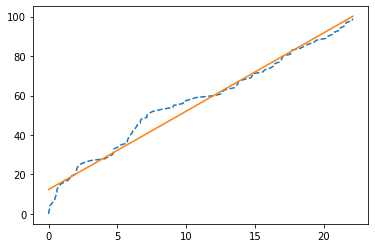

In [40]:
xHat = np.linspace(min(x), max(x), num=10000)
yHat = predict(xHat, alpha,fit_breaks)
plt.figure()
plt.plot(x, y, '--')
plt.plot(xHat, yHat, '-')
plt.show()

In [44]:
'''
Use Pwlf library to learn the liner regression functions
This libray make use of differntial evolution optimization to learn the breakpoints locations
instead of learning them iteratively using gradient descent. 
'''
my_pwlf = pwlf.PiecewiseLinFit(x, y)
# fit the data for four line segments
res = my_pwlf.fit(4)
# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

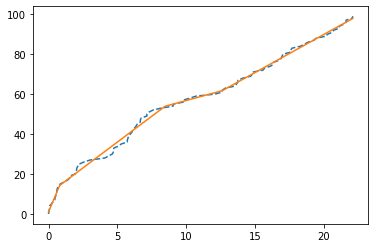

In [45]:
# plot the results
plt.figure()
plt.plot(x, y, '--')
plt.plot(xHat, yHat, '-')
plt.show()